In [ ]:
import coiled
import dask
from dask.distributed import Client
import dask.dataframe as dd

import pandas as pd
import matplotlib.pyplot as plt

# Accessing 80GB+ of residential energy usage data

This notebook accompanies the blog post **[A Changing Energy Landscape - Analyzing 8 Million American Homes]()** and is a jumping board to large scale analytics of this important topic.

The synthetic dataset made available by Keith Pasko and Otherlab represents residential energy consumption for **50,000 households on an hourly basis over 365 days**.

It's available for download at `s3://coiled-data/residential-electricity-ts`.

The dataset contains hourly energy consuption on the appliance level (66 features) for every household. The data is organized into directories, where directory name is the household ID. Every directory contains a years' worth of hourly observations.

Let's dive in and explore!

## Read in a single home example

We can use `pandas` to read in a single CSV (5MB) representing the yearly usage at a single household.

In [2]:
pdf = pd.read_csv("s3://coiled-data/residential-electricity-ts/samples1/5f7664ce434235066df7c3d5/enduse_timeseries.csv")
pdf.head()

,Time,TimeDST,TimeUTC,total_site_electricity_kwh,net_site_electricity_kwh,electricity_heating_kwh,electricity_central_system_heating_kwh,electricity_cooling_kwh,electricity_central_system_cooling_kwh,electricity_interior_lighting_kwh,...,electricity_pool_pump_kwh,electricity_hot_tub_heater_kwh,natural_gas_hot_tub_heater_therm,electricity_hot_tub_pump_kwh,natural_gas_grill_therm,natural_gas_lighting_therm,natural_gas_fireplace_therm,electricity_well_pump_kwh,electricity_recirc_pump_kwh,electricity_vehicle_kwh
0,2017/01/01 01:00:00,2017/01/01 01:00:00,2017/01/01 06:00:00,0.756245,0.756245,0.030662,0.0,0.0,0.0,0.034515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017/01/01 02:00:00,2017/01/01 02:00:00,2017/01/01 07:00:00,0.696297,0.696297,0.029431,0.0,0.0,0.0,0.020709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017/01/01 03:00:00,2017/01/01 03:00:00,2017/01/01 08:00:00,0.679682,0.679682,0.029219,0.0,0.0,0.0,0.013806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017/01/01 04:00:00,2017/01/01 04:00:00,2017/01/01 09:00:00,0.666049,0.666049,0.028834,0.0,0.0,0.0,0.013806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017/01/01 05:00:00,2017/01/01 05:00:00,2017/01/01 10:00:00,0.630894,0.630894,0.027286,0.0,0.0,0.0,0.015349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


8760 hours over 365 days.

In [3]:
pdf.shape

(8760, 69)

Let's compare the energy spent on heating vs. total energy used by this household over the first 96 hours of 2017.

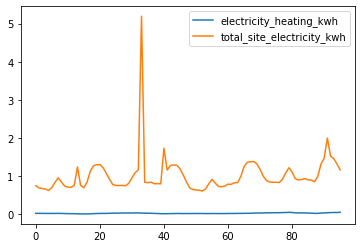

In [4]:
pdf[['electricity_heating_kwh', 'total_site_electricity_kwh']][:96].plot()

#### Total annual usage by appliance, 10 largest 

What are the 10 most significant energy expenses throughout the year?

In [5]:
pdf.iloc[:, 5:].sum(axis=0).nlargest(10)

electricity_interior_equipment_kwh    4511.513371
electricity_cooling_kwh               4230.221896
electricity_plug_loads_kwh            2203.282482
total_site_natural_gas_therm          1404.833077
natural_gas_heating_therm             1242.444012
electricity_fans_cooling_kwh          1111.756542
electricity_fans_heating_kwh           930.206927
electricity_interior_lighting_kwh      909.016434
electricity_clothes_dryer_kwh          782.980892
electricity_refrigerator_kwh           727.575102
dtype: float64

#### Visualizing consumption over 96 hours 

Let's look at how many appliances are active at this home. We'll do that by filtering out the appliances that have 0 use over the full year.

In [6]:
nonzero_cols = [ 
    c for c in pdf.columns[5:]
    if pdf[c].sum() > 0
]

print(f"Number of active columns for this household: {len(nonzero_cols)}")

Number of active columns for this household: 21


Now, let's plot the data:

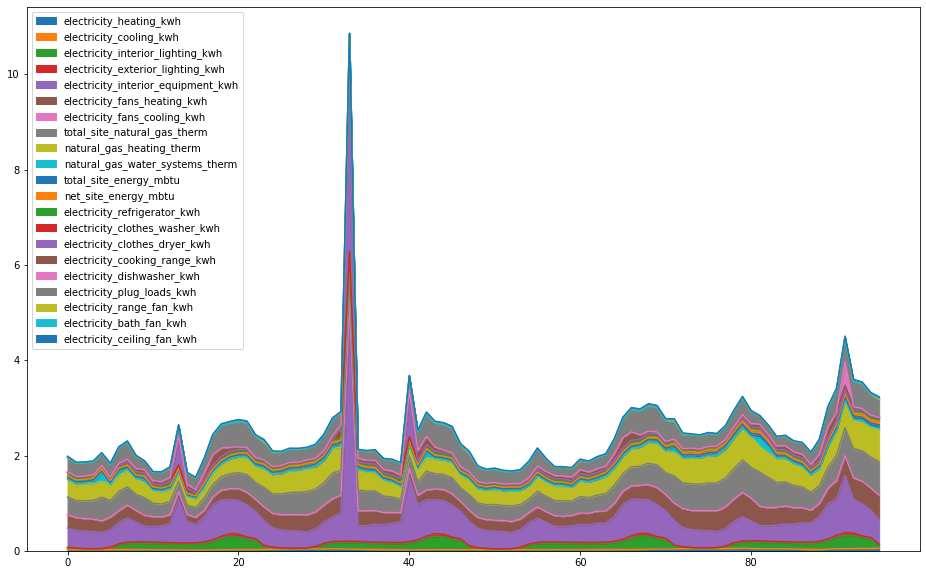

In [7]:
pdf[nonzero_cols][:96].plot.area(figsize=(16,10))

## Moving to the cluster: Read in a subsample

### Start a Dask cluster with Coiled

In [8]:
cluster = coiled.Cluster(n_workers=2)
client = Client(cluster)

Creating Cluster. This takes about a minute ...

/usr/local/anaconda3/lib/python3.8/site-packages/distributed/client.py:1136: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| cloudpickle | 1.5.0         | 1.6.0         | 1.6.0         |
| dask        | 2021.01.1     | 2021.02.0     | 2021.02.0     |
| distributed | 2021.01.1     | 2021.02.0     | 2021.02.0     |
| lz4         | None          | 3.1.3         | 3.1.3         |
| msgpack     | 1.0.0         | 1.0.2         | 1.0.2         |
| numpy       | 1.18.5        | 1.20.0        | 1.20.0        |
| python      | 3.8.5.final.0 | 3.8.6.final.0 | 3.8.6.final.0 |
| toolz       | 0.10.0        | 0.11.1        | 0.11.1        |
+-------------+---------------+---------------+---------------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.V

In [9]:
client

Client Scheduler: tls://ec2-3-17-207-9.us-east-2.compute.amazonaws.com:8786 Dashboard: http://ec2-3-17-207-9.us-east-2.compute.amazonaws.com:8787,Cluster Workers: 2 Cores: 8 Memory: 34.36 GB


### Load in the data

The data is organized into subdirectories, each of which represents one home.

Each home has the same CSV format with columns like we've seen in the example above.

When loading all the CSVs into a single, large Dask Dataframe, we need a way to differentiate which household does the specific table reference (as opposed to stacking them all together.)

Fortunately, the `dd.read_csv` method comes with a special keyword argument, `include_path_column`, which does what is says in the name: adds a column with the full source path to the dataframe.

In [10]:
url_21homes = "s3://coiled-data/residential-electricity-ts/samples1/5f7664*/*.csv"
url_allhomes = "s3://coiled-data/residential-electricity-ts/*/*/*.csv"

df = dd.read_csv(
    url_21homes, 
    storage_options={"anon":True},
    include_path_column=True
)

#### Scaling on demand

If you'd like to use all the homes data, change the variable within `dd.read_csv` to `url_allhomes`. 

In that case, you might want to scale the cluster to a larger size. You can do that straight from here using the cell below!

In [11]:
# cluster.scale(16) # This will scale the cluster to 16 worker nodes!

### Preview

In [12]:
df.head()

,Time,TimeDST,TimeUTC,total_site_electricity_kwh,net_site_electricity_kwh,electricity_heating_kwh,electricity_central_system_heating_kwh,electricity_cooling_kwh,electricity_central_system_cooling_kwh,electricity_interior_lighting_kwh,...,electricity_hot_tub_heater_kwh,natural_gas_hot_tub_heater_therm,electricity_hot_tub_pump_kwh,natural_gas_grill_therm,natural_gas_lighting_therm,natural_gas_fireplace_therm,electricity_well_pump_kwh,electricity_recirc_pump_kwh,electricity_vehicle_kwh,path
0,2017/01/01 01:00:00,2017/01/01 01:00:00,2017/01/01 09:00:00,4.596267,4.596267,4.092616,0.0,0.0,0.0,0.039284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coiled-data/residential-electricity-ts/samples...
1,2017/01/01 02:00:00,2017/01/01 02:00:00,2017/01/01 10:00:00,4.777729,4.777729,4.305858,0.0,0.0,0.0,0.023570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coiled-data/residential-electricity-ts/samples...
2,2017/01/01 03:00:00,2017/01/01 03:00:00,2017/01/01 11:00:00,5.067362,5.067362,4.599367,0.0,0.0,0.0,0.015714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coiled-data/residential-electricity-ts/samples...
3,2017/01/01 04:00:00,2017/01/01 04:00:00,2017/01/01 12:00:00,5.208116,5.208116,4.742417,0.0,0.0,0.0,0.015714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coiled-data/residential-electricity-ts/samples...
4,2017/01/01 05:00:00,2017/01/01 05:00:00,2017/01/01 13:00:00,5.218556,5.218556,4.766297,0.0,0.0,0.0,0.017470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coiled-data/residential-electricity-ts/samples...


Note that we have one more column than previously: the `path` column, which in our case, references the individual household.

In [13]:
df['path'].head()

0    coiled-data/residential-electricity-ts/samples...
1    coiled-data/residential-electricity-ts/samples...
2    coiled-data/residential-electricity-ts/samples...
3    coiled-data/residential-electricity-ts/samples...
4    coiled-data/residential-electricity-ts/samples...
Name: path, dtype: category
Categories (21, object): ['coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample..., ..., 'coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample..., 'coiled-data/residential-electricity-ts/sample...]

### Type conversion

Convert Time column from string type to Timestamp with Dask Dataframe API

In [14]:
df['Time'] = dd.to_datetime(df['Time'])
df['TimeUTC'] = dd.to_datetime(df['TimeUTC'])

Create useful columns for groupby operations

In [15]:
df['day'] = df.Time.dt.day
df['month'] = df.Time.dt.month
df['weekday'] = df.Time.dt.weekday
df['hour'] = df.Time.dt.hour

Create a `household` column, by extracting the ID from file path

In [16]:
df['household'] = df['path'].str.split('/').str[-2]

Drop unused columns

In [17]:
df = df.drop(columns=['path', 'TimeDST'])

In [18]:
df = df.persist()

In [19]:
len(df)

183960

## Visualize

Try visualizing any questions you come up with!

We will try looking at times during the week when our sample homes use a clothes dryer. We'll run a groupby on our dataframe and plot a heatmap.

> (Optional) First, let's select Q1 of the year as a working dataset:

In [20]:
df_Q1 = df[df.month <= 3]

In [21]:
dryer_hours = df_Q1.groupby(['hour', 'weekday'])['electricity_clothes_dryer_kwh'].sum()

In [22]:
dh = dryer_hours.compute()

In [23]:
import seaborn as sns

In [24]:
dryer_week_cal = dh.reset_index().pivot(index = 'hour', columns='weekday', values='electricity_clothes_dryer_kwh')

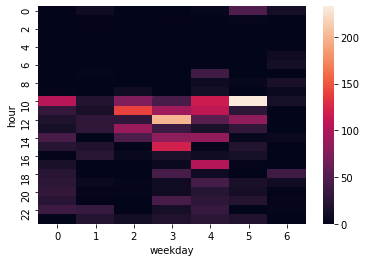

In [25]:
sns.heatmap(dryer_week_cal)

Now let's plot that aggregation on the hourly axis only:

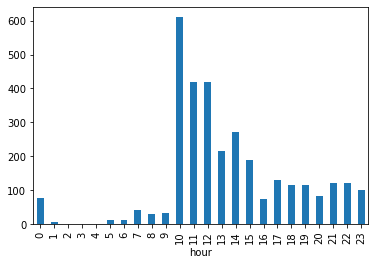

In [26]:
dh.reset_index().groupby('hour')['electricity_clothes_dryer_kwh'].sum().plot.bar()

Quack quack! Well, this is not a duck curve, but what if clothes drying could be timed for peak solar production?

## Save to parquet

After we've read our CSV dataset and done the preprocessing work on our columns, we can invest in faster loading times and smaller spatial footprint of our data.

**Parquet** is a binary data storage format designed for big datasets, data lakes, and modern engineering workflows. Because it's binary, it cannot be read without decoding (unlike CSV or JSON)

It's main advantages are:

* columnar storage - we can read only the specific columns we care about from disk, saving time.
* compression - efficient compression formats leverage the fact that network transfer of a smaller file followed by on-the-fly decompression on the host processor is usually much faster than sending a much larger, decompressed file.

By saving the dataset in Parquet, we make it easier to work with in future iterations.

Dask and Pandas Dataframes support saving to this format, with engine libraries such as `pyarrow`, `fastparquet` and `snappy-python`

In [27]:
df.npartitions

21

_If you wish, save the parquet data sample locally or to your own s3 bucket_

## Custom software

One of the tasks Keith and his team are working on is time series comparison. One technique to get a decent metric is Dynamic Time Warping ([an interesting blog post describing DTW](https://medium.com/walmartglobaltech/time-series-similarity-using-dynamic-time-warping-explained-9d09119e48ec)).

This technique, albeit popular, is not directly implemented in the largest and most popular ML tools. Instead, in a very Pythonic, community-driven style, there are multiple small-scale contributions that are highly effective.

One of them is `fastdtw`, which uses `numba` to accelerate computation.

#### Select 2 homes and download heating timeseries

To run an example, let's get two individual homes and download the electric heating timeseries.

In [28]:
home1 = '5f7664a6434235066df7c37b'    

home1_heating = df.loc[df.household == home1, 'electricity_heating_kwh'].compute()

In [29]:
home2 = '5f7664a943423500bdb02d55'

home2_heating = df.loc[df.household == home2, 'electricity_heating_kwh'].compute()

#### Install `fastdtw` locally

In [30]:
!pip install fastdtw

#### Calculate distance using Dynamic Time Warping, with permitted radius of comparison equal to 6 hours.

In [30]:
from fastdtw import fastdtw

In [31]:
%%time
distance, path = fastdtw(home1_heating, home2_heating, radius=6)

distance

CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 17.4 ms


5140.1747625049575

#### Install `fastdtw` locally

In [44]:
from distributed.diagnostics.plugin import PipInstall

In [50]:
patch = PipInstall(packages=['fastdtw'])

In [60]:
client.register_worker_plugin(patch)

{'tls://10.2.11.112:40319': {'status': 'OK'},
 'tls://10.2.13.194:34091': {'status': 'OK'}}

Now our workers can use this library as well!

Read more about [Dynamic Time Warping](https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping) and comparing timeseries.

> This is a quick-and-dirty way of patching a cluster environment in an interactive session.


> **A better way(tm)** is to use a software environment - Coiled makes that really simple. Check out the cell below!

```Python
# This instruction will create a software env in your account.
coiled.create_software_environment(
    name='dynamic-time-warping', # <--- Name
    container="coiled/notebook:latest",
    conda={
        "channels": ["conda-forge"],
        "dependencies": [
            "python=3.8", 
            "coiled=0.0.37"
            "dask-ml",
            "dask>=2.23.0",
            "fastparquet",
            "matplotlib",
            "pandas>=1.1.0",
            "python-snappy",
            "scikit-learn"
      ]
    },
    pip=["fastdtw"],
)
```

Then, you can launch a cluster with this environment like so:


```Python
cluster = coiled.Cluster(
    n_workers=4
    software='dynamic-time-warping'
)
```

#### Prepare a tabular view of 1 months Cooling Electricity for all households  

In [37]:
july = df[df.month == 7]

In [38]:
july['day'] = july.Time.dt.day

In [39]:
july['day-hr'] = (july['day'].astype(str).str.cat(july['hour'].astype(str), sep='-'))

In [40]:
july = dd.categorical.categorize(
    july, 
    columns=['day-hr', 'household']
)

In [41]:
cooling_summer_pivot = july.reset_index().pivot_table(index='household', columns='day-hr', values='electricity_cooling_kwh')

In [42]:
cooling_summer_pivot

,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,1-18,1-19,1-20,1-21,1-22,1-23,2-0,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10,2-11,2-12,2-13,2-14,2-15,2-16,2-17,2-18,2-19,2-20,2-21,2-22,2-23,3-0,3-1,3-2,3-3,3-4,3-5,3-6,3-7,3-8,3-9,3-10,3-11,3-12,3-13,3-14,3-15,3-16,3-17,3-18,3-19,3-20,3-21,3-22,3-23,4-0,4-1,4-2,4-3,4-4,4-5,4-6,4-7,4-8,4-9,4-10,4-11,4-12,4-13,4-14,4-15,4-16,4-17,4-18,4-19,4-20,4-21,4-22,4-23,5-0,5-1,5-2,5-3,5-4,5-5,5-6,5-7,5-8,5-9,5-10,5-11,5-12,5-13,5-14,5-15,5-16,5-17,5-18,5-19,5-20,5-21,5-22,5-23,6-0,6-1,6-2,6-3,6-4,6-5,6-6,6-7,6-8,6-9,6-10,6-11,6-12,6-13,6-14,6-15,6-16,6-17,6-18,6-19,6-20,6-21,6-22,6-23,7-0,7-1,7-2,7-3,7-4,7-5,7-6,7-7,7-8,7-9,7-10,7-11,7-12,7-13,7-14,7-15,7-16,7-17,7-18,7-19,7-20,7-21,7-22,7-23,8-0,8-1,8-2,8-3,8-4,8-5,8-6,8-7,8-8,8-9,8-10,8-11,8-12,8-13,8-14,8-15,8-16,8-17,8-18,8-19,8-20,8-21,8-22,8-23,9-0,9-1,9-2,9-3,9-4,9-5,9-6,9-7,9-8,9-9,9-10,9-11,9-12,9-13,9-14,9-15,9-16,9-17,9-18,9-19,9-20,9-21,9-22,9-23,10-0,10-1,10-2,10-3,10-4,10-5,10-6,10-7,10-8,10-9,10-10,10-11,10-12,10-13,10-14,10-15,10-16,10-17,10-18,10-19,10-20,10-21,10-22,10-23,11-0,11-1,11-2,11-3,11-4,11-5,11-6,11-7,11-8,11-9,11-10,11-11,11-12,11-13,11-14,11-15,11-16,11-17,11-18,11-19,11-20,11-21,11-22,11-23,12-0,12-1,12-2,12-3,12-4,12-5,12-6,12-7,12-8,12-9,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,13-0,13-1,13-2,13-3,13-4,13-5,13-6,13-7,13-8,13-9,13-10,13-11,13-12,13-13,13-14,13-15,13-16,13-17,13-18,13-19,13-20,13-21,13-22,13-23,14-0,14-1,14-2,14-3,14-4,14-5,14-6,14-7,14-8,14-9,14-10,14-11,14-12,14-13,14-14,14-15,14-16,14-17,14-18,14-19,14-20,14-21,14-22,14-23,15-0,15-1,15-2,15-3,15-4,15-5,15-6,15-7,15-8,15-9,15-10,15-11,15-12,15-13,15-14,15-15,15-16,15-17,15-18,15-19,15-20,15-21,15-22,15-23,16-0,16-1,16-2,16-3,16-4,16-5,16-6,16-7,16-8,16-9,16-10,16-11,16-12,16-13,16-14,16-15,16-16,16-17,16-18,16-19,16-20,16-21,16-22,16-23,17-0,17-1,17-2,17-3,17-4,17-5,17-6,17-7,17-8,17-9,17-10,17-11,17-12,17-13,17-14,17-15,17-16,17-17,17-18,17-19,17-20,17-21,17-22,17-23,18-0,18-1,18-2,18-3,18-4,18-5,18-6,18-7,18-8,18-9,18-10,18-11,18-12,18-13,18-14,18-15,18-16,18-17,18-18,18-19,18-20,18-21,18-22,18-23,19-0,19-1,19-2,19-3,19-4,19-5,19-6,19-7,19-8,19-9,19-10,19-11,19-12,19-13,19-14,19-15,19-16,19-17,19-18,19-19,19-20,19-21,19-22,19-23,20-0,20-1,20-2,20-3,20-4,20-5,20-6,20-7,20-8,20-9,20-10,20-11,20-12,20-13,20-14,20-15,20-16,20-17,20-18,20-19,20-20,20-21,20-22,20-23,21-0,21-1,21-2,21-3,21-4,21-5,21-6,21-7,21-8,21-9,21-10,21-11,21-12,21-13,21-14,21-15,21-16,21-17,21-18,21-19,21-20,21-21,21-22,21-23,22-0,22-1,22-2,22-3,22-4,22-5,22-6,22-7,22-8,22-9,22-10,22-11,22-12,22-13,22-14,22-15,22-16,22-17,22-18,22-19,22-20,22-21,22-22,22-23,23-0,23-1,23-2,23-3,23-4,23-5,23-6,23-7,23-8,23-9,23-10,23-11,23-12,23-13,23-14,23-15,23-16,23-17,23-18,23-19,23-20,23-21,23-22,23-23,24-0,24-1,24-2,24-3,24-4,24-5,24-6,24-7,24-8,24-9,24-10,24-11,24-12,24-13,24-14,24-15,24-16,24-17,24-18,24-19,24-20,24-21,24-22,24-23,25-0,25-1,25-2,25-3,25-4,25-5,25-6,25-7,25-8,25-9,25-10,25-11,25-12,25-13,25-14,25-15,25-16,25-17,25-18,25-19,25-20,25-21,25-22,25-23,26-0,26-1,26-2,26-3,26-4,26-5,26-6,26-7,26-8,26-9,26-10,26-11,26-12,26-13,26-14,26-15,26-16,26-17,26-18,26-19,26-20,26-21,26-22,26-23,27-0,27-1,27-2,27-3,27-4,27-5,27-6,27-7,27-8,27-9,27-10,27-11,27-12,27-13,27-14,27-15,27-16,27-17,27-18,27-19,27-20,27-21,27-22,27-23,28-0,28-1,28-2,28-3,28-4,28-5,28-6,28-7,28-8,28-9,28-10,28-11,28-12,28-13,28-14,28-15,28-16,28-17,28-18,28-19,28-20,28-21,28-22,28-23,29-0,29-1,29-2,29-3,29-4,29-5,29-6,29-7,29-8,29-9,29-10,29-11,29-12,29-13,29-14,29-15,29-16,29-17,29-18,29-19,29-20,29-21,29-22,29-23,30-0,30-1,30-2,30-3,30-4,30-5,30-6,30-7,30-8,30-9,30-10,30-11,30-12,30-13,30-14,30-15,30-16,30-17,30-18,30-19,30-20,30-21,30-22,30-23,31-0,31-1,31-2,31-3,31-4,31-5,31-6,31-7,31-8,31-9,31-10,31-11,31-12,31-13,31-14,31-15,31-16,31-17,31-18,31-19,31-20,31-21,31-22,31-23
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [43]:
cooling_summer_pivot.head()

day-hr,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,...,31-14,31-15,31-16,31-17,31-18,31-19,31-20,31-21,31-22,31-23
household,,,,,,,,,,,,,,,,,,,,,
5f7664a6434235066df7c37b,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5f7664a943423500bdb02d55,0.089749,0.058589,0.00000,0.031184,0.000823,0.160201,0.125233,0.339024,0.387307,0.501456,...,1.404721,1.505677,1.804142,1.664911,1.481975,1.139733,0.990725,0.905683,0.558015,0.523348
5f7664ac43423500bdb02d5d,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5f7664b243423500bdb02d70,0.396590,0.292276,0.20196,0.131175,0.054891,0.135624,0.071840,0.026642,0.019683,0.025770,...,0.622803,0.776703,1.079111,0.948046,0.996887,1.013812,1.052770,0.688493,0.525394,0.246095
5f7664b24342350688f7c373,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.380633,0.399381,0.503075,0.498118,0.494089,0.447400,0.416206,0.379602,0.284275,0.217731


<kbd>**Exercise**</kbd> 
### Can you structure efficient, distributed pairwise-distance computation?

A distance matrix can be used for various clustering approaches, like the [hierarchical clustering family of algorithms](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

Practice on a small subsample and rein in the computational complexity, and then scale out! :)

## Next steps:

* Apply a different clustering approach to the home energy consumption data ([Dask-ML](https://ml.dask.org/modules/generated/dask_ml.cluster.SpectralClustering.html))
* Join home usage patterns with descriptive metadata, including geographical coordinates.
* Visualize the clusters on a map.